Update summary

modhis.py and hispec.py: 

new instrument/telescope throughput and new instrument/telescope emissivity, now function about ao coupling, new Strehl ratio

Observation.py: 

add function of signal mode observation(on-axis)

add function of sky and instrument noise

Telescope.py

update the telescope throughput of TMT and Keck

--
details:
in addition to updating the throughput of instruments and telescopes, this update fully incorporates the calculation method of AO coupling used by Ashley into PSIsim.

For the new AO mode, the new AO band magnitude acquisition function has been updated. The new function needs to input the AO filter, band, ao_booster and object temperature. In addition, AO module also added two parameters: ao_ho_wfe and ao_tt_dynamic. To get them we need to use "spectrum.ao_coupling"

For "spectrum.ao_coupling", we need to input: instrument, ao mode, ao filter, ao band, and ao band magnitude.

All updates are bracketed by "####" and descriptions are written for each update

First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 
from psisim import datadir
from psisim import spectrum
import psisim.nair as nair
SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Tried importing picaso, but couldn't do it


/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_7584/3990040308.py:10: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import median_filter


## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
#this needs to be modified
path = '/Users/huihaoz/Downloads/psisim-kpic/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [3]:
TMT = telescope.TMT(path=path)
TMT.airmass=1.2
TMT.water_vapor=1.5
TMT.seeing = TMT.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [4]:
#Initialize a modhis object and set the current filter
modhis = instrument.modhis(telescope=TMT)
modhis.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = np.arange(0.5,2.5,1e-3)*u.um #modhis.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
modhis.set_observing_mode(3600*4,1,'TwoMASS-K', wavelengths,mode="off-axis", vortex_charge=1) 

MODHIS is mostly untested at this point


/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")


## Generate some Spectra

We can now generate a host spectrum

In [5]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.5*u.dex(u.cm/ u.s**2),"StarTeff":2800*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0.001*u.km/u.s,
                    "StarVsini":0.001*u.km/u.s,
                    "StarLimbDarkening":0.001}


#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',14.0,filters,modhis.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=modhis.current_dwvs)


In [6]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/ u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":0.000020*u.km/u.s,"StarVsini": 0.000010*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',19,filters,modhis.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=modhis.current_dwvs)

### ao_booster

In [7]:
#input: mag of star, filter and band, Teff
f0 = spectrum.scale_stellar(14.0,'TwoMASS-K',2800*u.K,path=path)

### modhis ao parameters

In [8]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] =spectrum.get_band_mag(family='Johnson',band='R',factor_0=f0,teff_s=2800*u.K,path=path)

#only johnson-R so far
modhis.ao_mag = host_properties["StarAOmag"]

modhis.ao_ho_wfe, modhis.ao_tt_dynamic = spectrum.ao_coupling(instrument='modhis',ao_mode='LGS_OFF',ao_filter='Johnson',ao_band_mag=modhis.ao_mag )

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

### Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [9]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
obj_spec,total_noise,stellar_spec,thermal_spec = observation.simulate_observation(TMT,modhis,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False)

Text(0, 0.5, 'Spectrum [electron um / micron]')

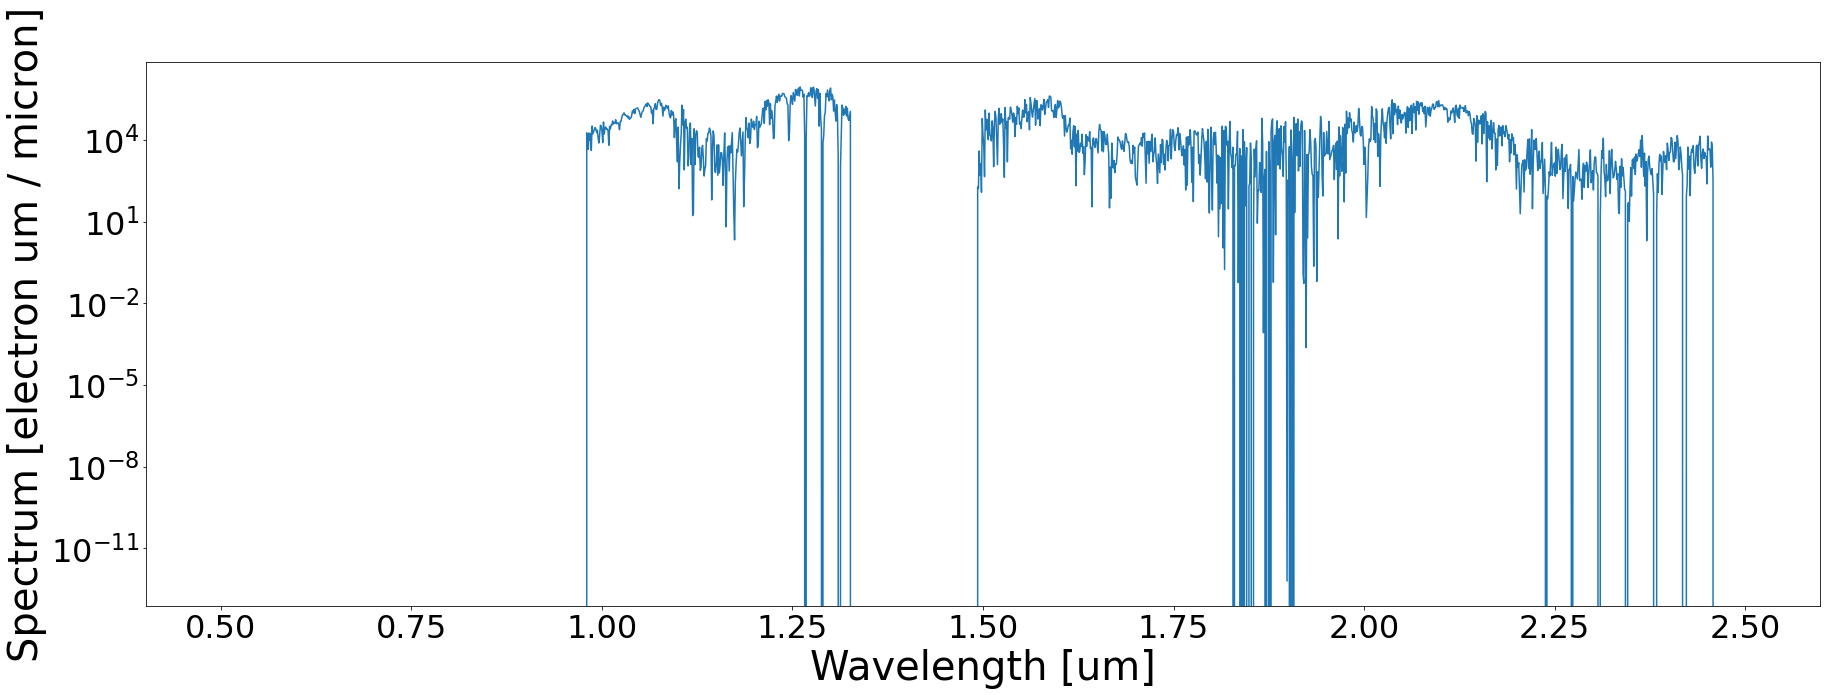

In [11]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)

In [12]:
all_wavelengths = []
full_host_spectrum = []
full_obj_spectrum = []
full_obj_spectrum_nosky = []
full_total_noise = []
full_thermal_spec = []
full_noise_components = []
full_speckle_noise = []


for modhis_filter in modhis.filters:
    
    #Setup the instrument
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(3600*4,1,modhis_filter, wavelengths, mode='off-axis') 
    
    
    host_user_params = (path,'TwoMASS-K',14.0,filters,modhis.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=modhis.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',19.0,filters,modhis.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=modhis.current_dwvs)
    
    obj_spectrum.spectrum /= host_spectrum.spectrum
    
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components= observation.simulate_observation(TMT,modhis,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=True)
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(TMT,modhis,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=False)

    full_speckle_noise.append(modhis.get_speckle_noise(0.4*u.arcsecond,modhis.ao_mag,modhis.current_filter,
                                             wavelengths,host_properties['StarSpT'],TMT)[0])
    all_wavelengths.append(wavelengths)
    full_host_spectrum.append(stellar_spec)
    full_obj_spectrum.append(obj_spec)
    full_obj_spectrum_nosky.append(obj_spec_no_sky)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_noise_components.append(noise_components)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_host_spectrum = np.hstack(full_host_spectrum).value*stellar_spec.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_obj_spectrum_nosky = np.hstack(full_obj_spectrum_nosky).value*obj_spec_no_sky.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_noise_components = np.hstack(full_noise_components)*obj_spec.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_speckle_noise = np.hstack(full_speckle_noise)

/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the mom

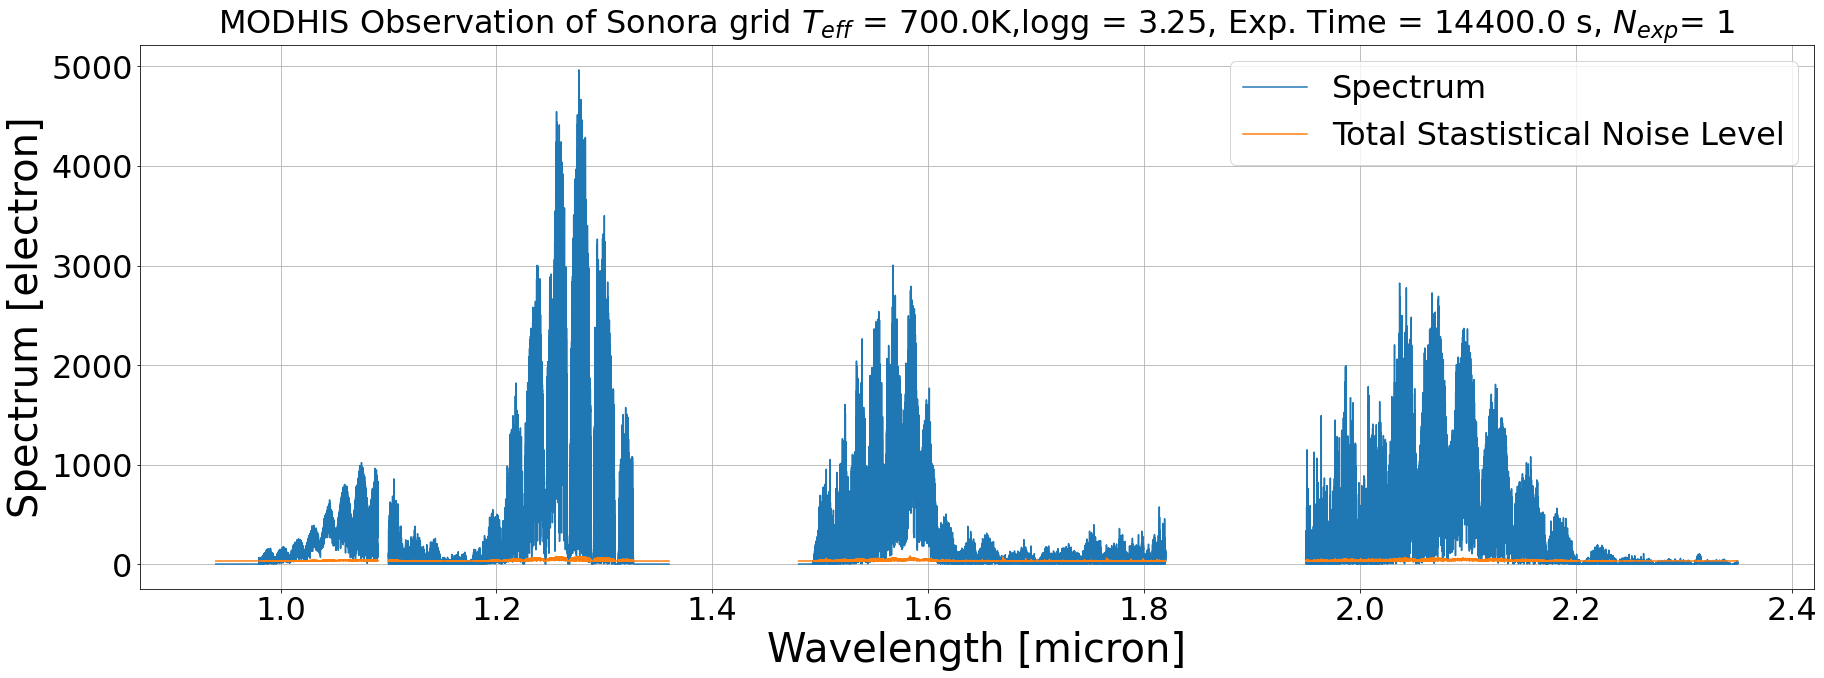

In [13]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

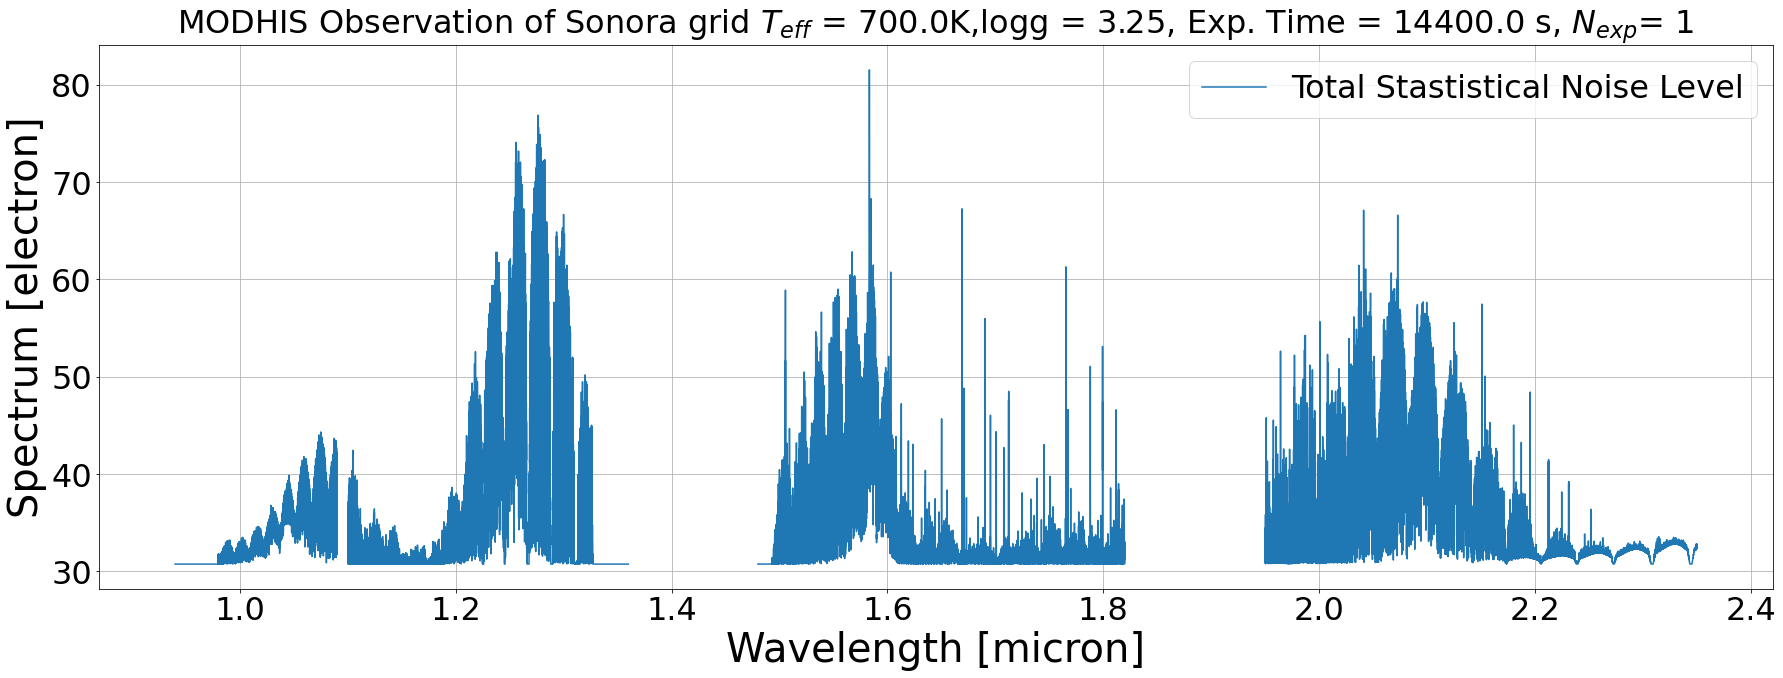

In [14]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

## single object observation

In [15]:
all_wavelengths = []
full_obj_spectrum = []
full_total_noise = []
full_thermal_spec = []
full_throughput = []


for modhis_filter in modhis.filters:
    
    #Setup the instrument
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(3600*4,1,modhis_filter, wavelengths, mode='off-axis') 
    
    
    host_user_params = (path,'TwoMASS-K',14.0,filters,modhis.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=modhis.current_dwvs)
    
    obj_spec,total_noise,thermal_spec,total_th= observation.simulate_observation_singletarget(TMT,modhis,
                                                                                      host_spectrum.wvs,
                                                                                      host_spectrum.spectrum,
                                                                                      sky_on = False, 
                                                                                      post_processing_gain = 1, 
                                                                                      return_noise_components = False,
                                                                                      apply_lsf = False, 
                                                                                      integrate_delta_wv = False)


    all_wavelengths.append(wavelengths)
    full_obj_spectrum.append(obj_spec)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_throughput.append(total_th)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_throughput = np.hstack(full_throughput)

/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")


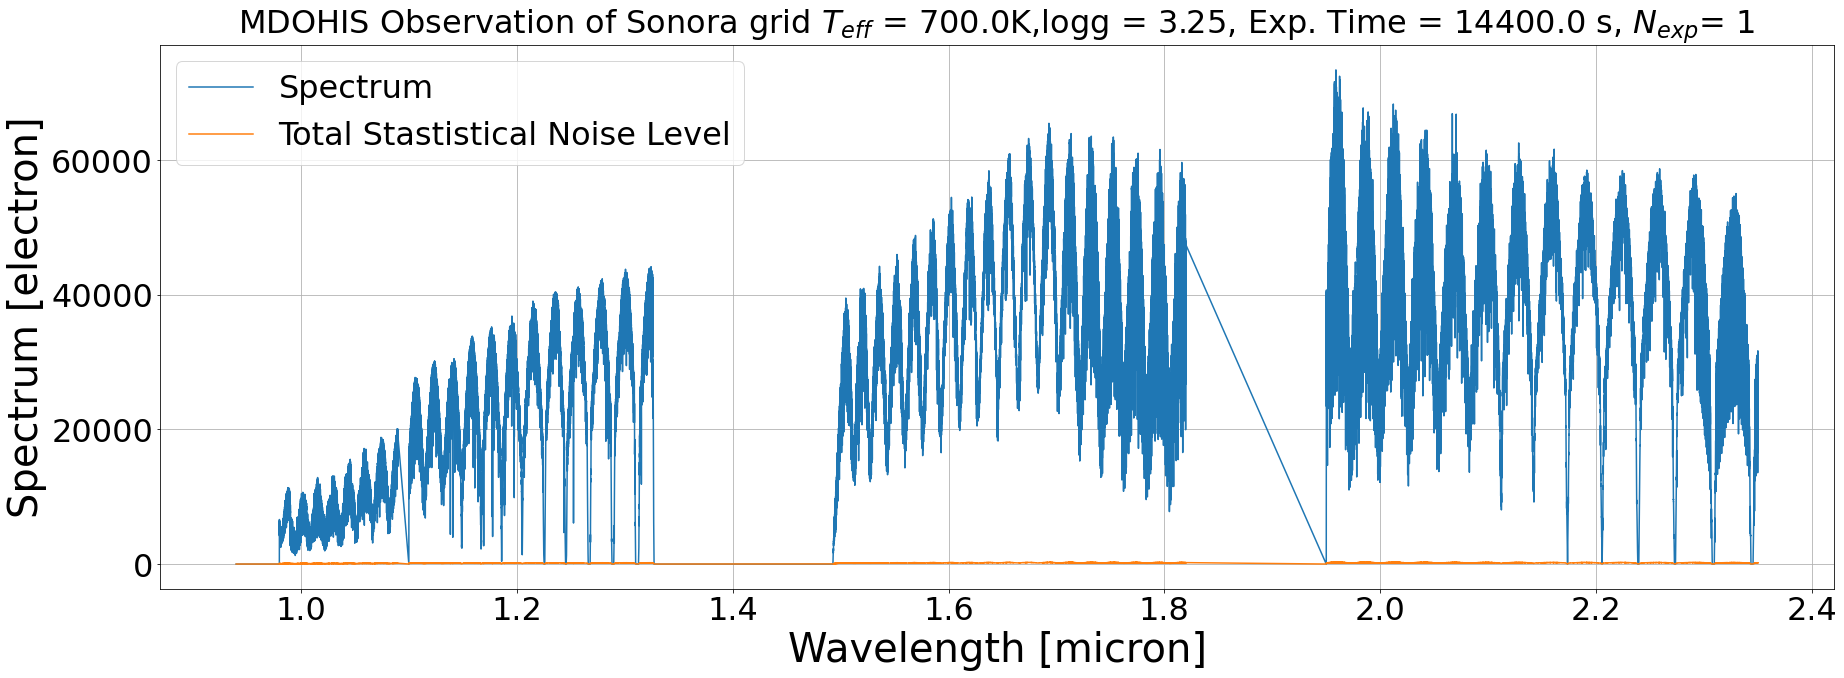

In [16]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"MDOHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

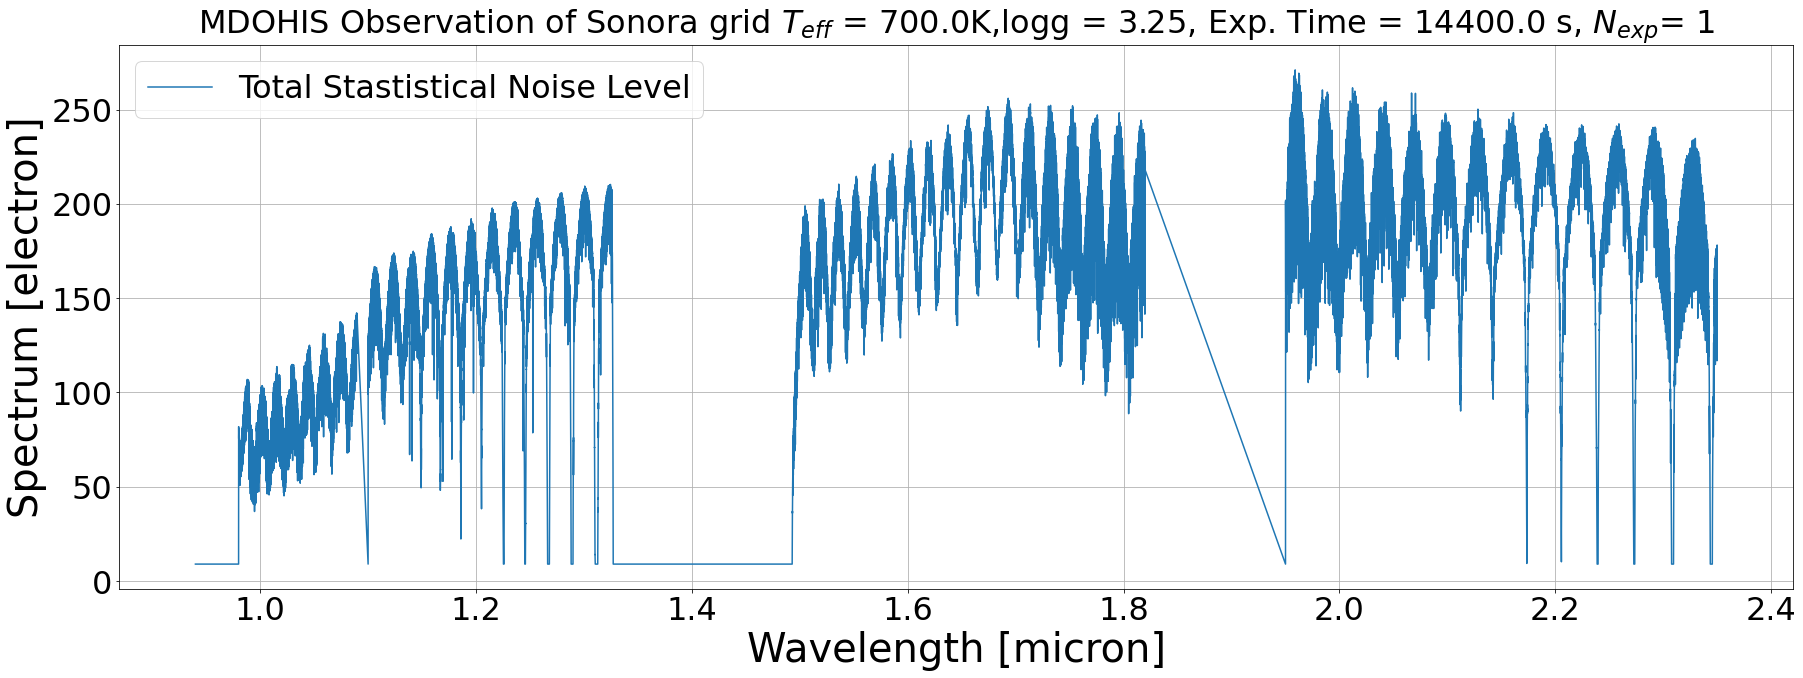

In [17]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"MDOHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

# HISPEC


In [18]:
keck = telescope.Keck(path=path)
keck.airmass=1.2
keck.water_vapor=1.5
keck.seeing = keck.median_seeing

In [19]:
#Initialize a hispec object and set the current filter
hispec = instrument.hispec(telescope=keck)
hispec.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = np.arange(0.5,2.5,1e-3)*u.um 

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
hispec.set_observing_mode(3600*4,1,'TwoMASS-K', wavelengths,mode="off-axis") 




In [20]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.50*u.dex(u.cm/ u.s**2),"StarTeff":2800*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                   "StarRadialVelocity":0.001*u.km/u.s,
                    "StarVsini":0.001*u.km/u.s,
                    "StarLimbDarkening":0.001}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',14.0,filters,hispec.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=hispec.current_dwvs)



In [21]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/ u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":0.000020*u.km/u.s,"StarVsini":0.000010*u.km/u.s,
                  "StarLimbDarkening":0.9}

obj_user_params = (path,'TwoMASS-K',19,filters,hispec.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,hispec.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=hispec.current_dwvs)


In [22]:
f0 = spectrum.scale_stellar(14.0,'TwoMASS-K',2800*u.K,path=path)

In [23]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 400 *u.mas

#Get the host star magnitude in the AO filter
#note that the band needs to be consistent with AO data file
host_properties["StarAOmag"] = spectrum.get_band_mag(family='Johnson',band='J',factor_0=f0,teff_s=2800*u.K,path=path)

#modhis.ao_mag = host_properties["StarAOmag"]
hispec.ao_mag = host_properties["StarAOmag"]

hispec.ao_ho_wfe, hispec.ao_tt_dynamic = spectrum.ao_coupling(instrument='hispec',ao_mode='LGS_100J_45',ao_filter='Johnson',ao_band_mag=hispec.ao_mag )

#modhis doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

In [24]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [25]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,hispec,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False)

Text(0, 0.5, 'Spectrum [electron um / micron]')

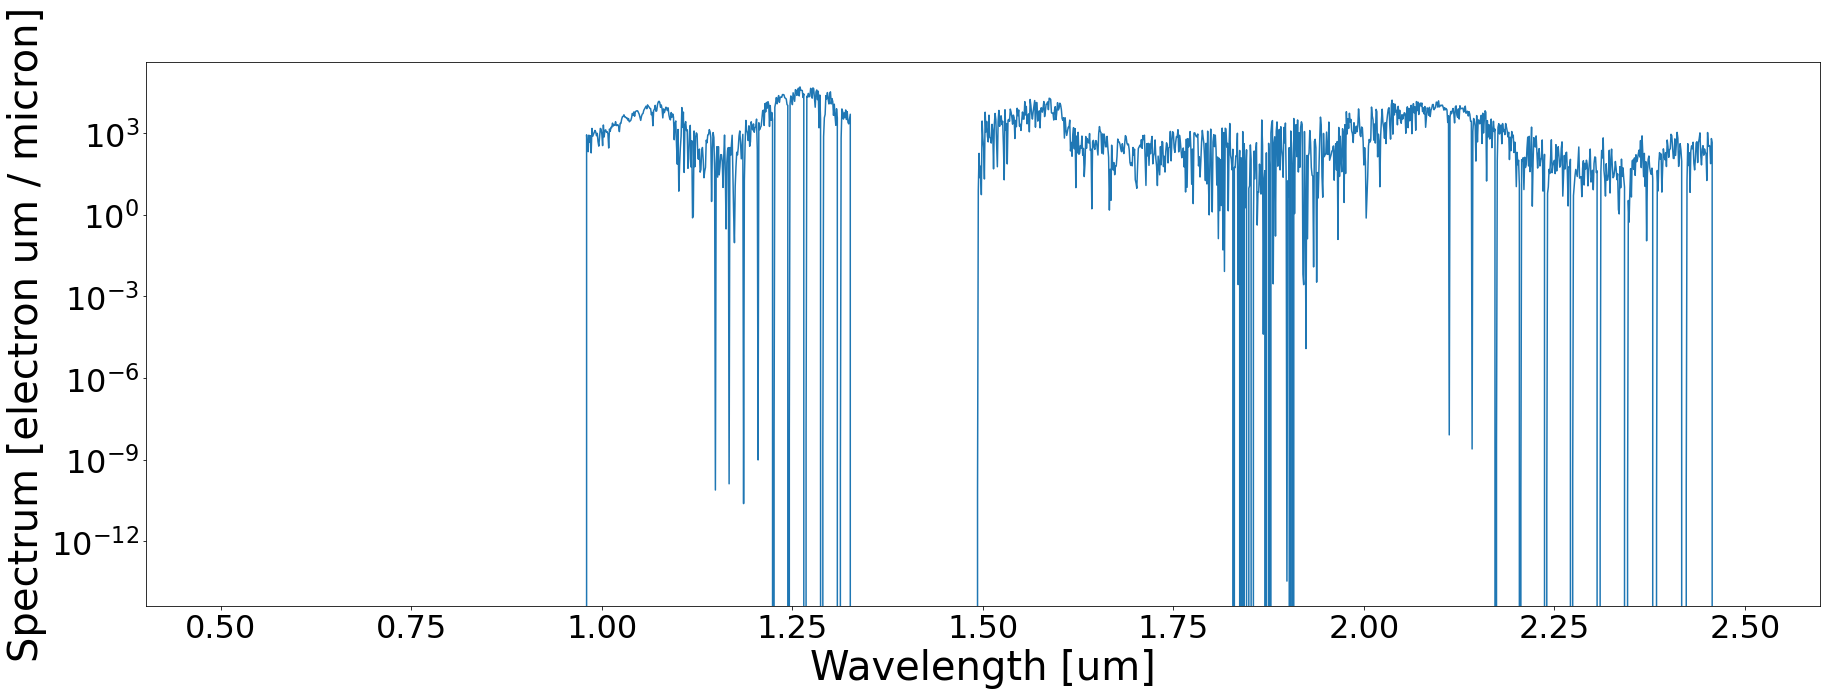

In [26]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
#plt.ylim(1e-4,2e2)

## Run a simulation, off-axis

In [27]:
all_wavelengths = []
full_host_spectrum = []
full_obj_spectrum = []
full_obj_spectrum_nosky = []
full_total_noise = []
full_thermal_spec = []
full_noise_components = []
full_speckle_noise = []


for hispec_filter in hispec.filters:
    
    #Setup the instrument
    hispec.set_current_filter(hispec_filter)
    wavelengths = hispec.get_wavelength_range()
    hispec.set_observing_mode(3600*4,1,hispec_filter, wavelengths, mode='off-axis') 
    
    
    host_user_params = (path,'TwoMASS-K',14.0,filters,hispec.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=hispec.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',19.0,filters,hispec.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,hispec.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=hispec.current_dwvs)
    
    obj_spectrum.spectrum /= host_spectrum.spectrum
    
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components= observation.simulate_observation(keck,hispec,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=True)
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,hispec,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=False,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=False)

    full_speckle_noise.append(hispec.get_speckle_noise(0.4*u.arcsecond,hispec.ao_mag,hispec.current_filter,
                                             wavelengths,host_properties['StarSpT'],keck)[0])
    all_wavelengths.append(wavelengths)
    full_host_spectrum.append(stellar_spec)
    full_obj_spectrum.append(obj_spec)
    full_obj_spectrum_nosky.append(obj_spec_no_sky)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_noise_components.append(noise_components)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_host_spectrum = np.hstack(full_host_spectrum).value*stellar_spec.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_obj_spectrum_nosky = np.hstack(full_obj_spectrum_nosky).value*obj_spec_no_sky.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_noise_components = np.hstack(full_noise_components)*obj_spec.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_speckle_noise = np.hstack(full_speckle_noise)

/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


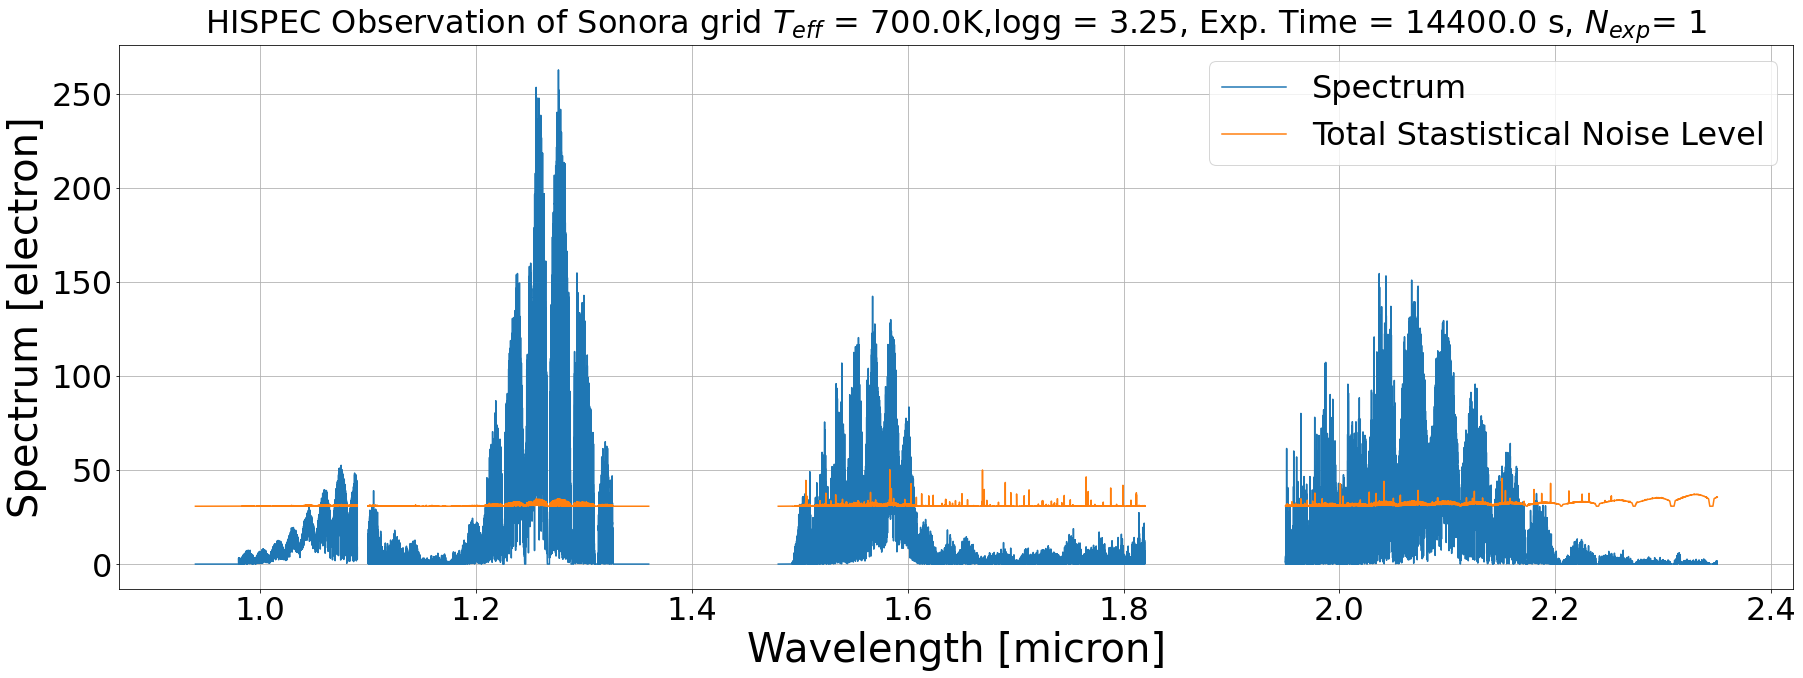

In [28]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"HISPEC Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,hispec.exposure_time,hispec.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

## Run a simulation, on-axis

In [29]:
all_wavelengths = []
full_obj_spectrum = []
full_total_noise = []
full_thermal_spec = []
full_throughput = []


for hispec_filter in hispec.filters:
    
    #Setup the instrument
    hispec.set_current_filter(hispec_filter)
    wavelengths = hispec.get_wavelength_range()
    hispec.set_observing_mode(3600*4,1,hispec_filter, wavelengths, mode='off-axis') 
    
    
    host_user_params = (path,'TwoMASS-K',14.0,filters,hispec.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,hispec.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=hispec.current_dwvs)
    
    obj_spec,total_noise,thermal_spec,total_th= observation.simulate_observation_singletarget(keck,hispec,
                                                                                      host_spectrum.wvs,
                                                                                      host_spectrum.spectrum,
                                                                                      sky_on = False, 
                                                                                      post_processing_gain = 1, 
                                                                                      return_noise_components = False,
                                                                                      apply_lsf = False, 
                                                                                      integrate_delta_wv = False)


    all_wavelengths.append(wavelengths)
    full_obj_spectrum.append(obj_spec)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_throughput.append(total_th)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_throughput = np.hstack(full_throughput)

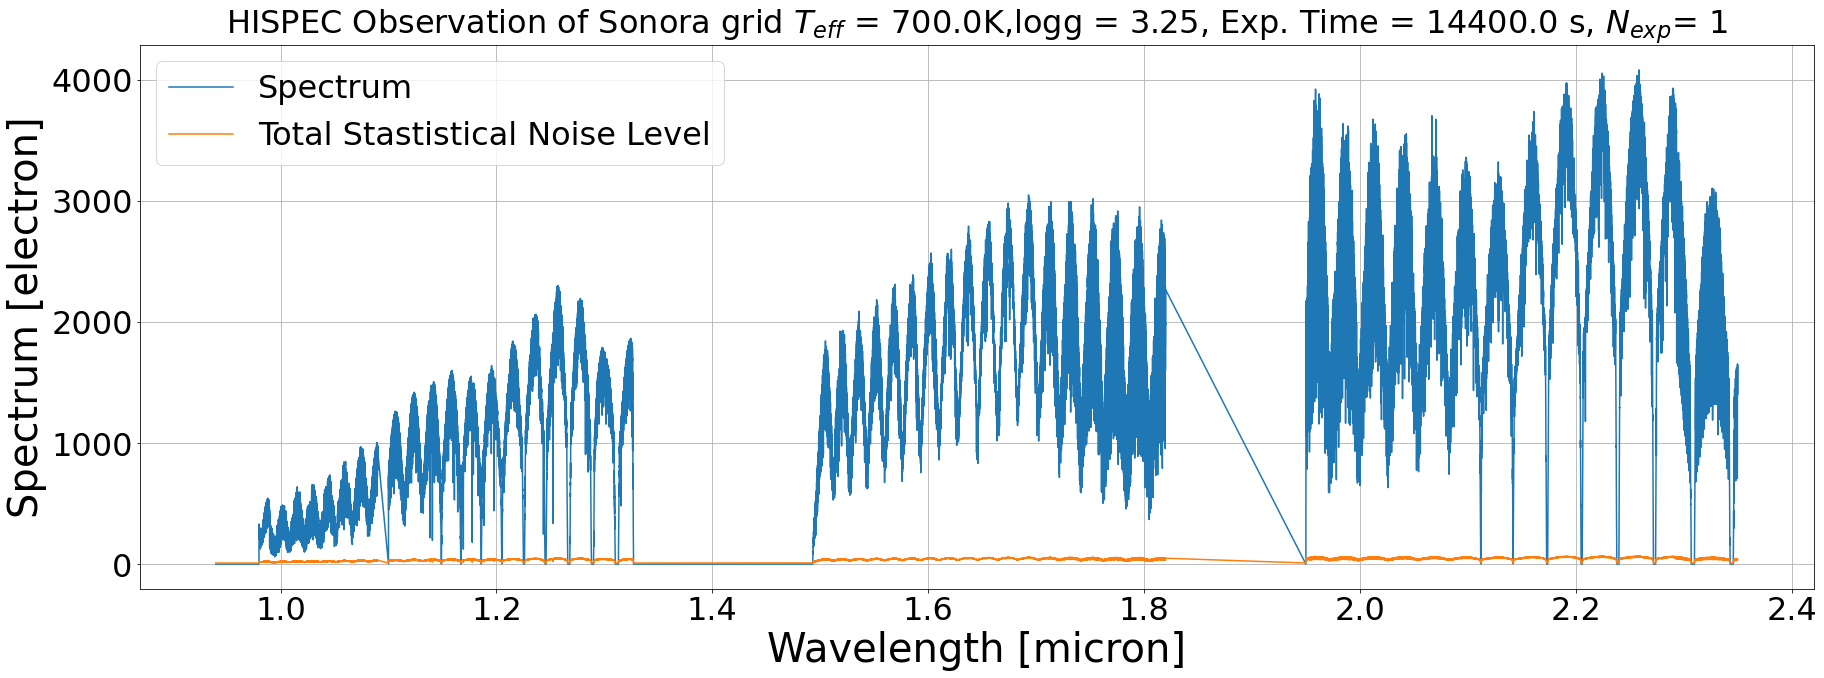

In [30]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"HISPEC Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,hispec.exposure_time,hispec.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

# plot the sky and instrument, telescope, for TMT-MODHIS

In [35]:
all_wavelengths = []
full_sky = []
full_tele = []
full_inst = []
full_dark = []


for modhis_filter in modhis.filters:
    
    #Setup the instrument
    modhis.set_current_filter(modhis_filter)
    wavelengths = modhis.get_wavelength_range()
    modhis.set_observing_mode(3600*4,1,modhis_filter, wavelengths, mode='off-axis') 
    
    
    host_user_params = (path,'TwoMASS-K',14.0,filters,modhis.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,modhis.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=modhis.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',19.0,filters,modhis.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,modhis.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=modhis.current_dwvs)
    
    obj_spectrum.spectrum /= host_spectrum.spectrum
    
    sky, tele, inst, dark=observation.simulate_bg(TMT,modhis,host_properties,obj_spectrum.spectrum,wavelengths,1e5,verbose=True,
                                                                                       post_processing_gain = 10,
                                                                                      stellar_spec=host_spectrum.spectrum)
    all_wavelengths.append(wavelengths)
    full_sky.append(sky)
    full_tele.append(tele)
    full_inst.append(inst)
    full_dark.append(dark)


all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_sky = np.hstack(full_sky).value*sky.unit
full_tele = np.hstack(full_tele).value*tele.unit
full_inst = np.hstack(full_inst).value*inst.unit
full_dark = np.hstack(full_dark).value*dark.unit

/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the moment
  warnings.warn("Modes other than 'vfn' are not tested at the moment")
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/huihaoz/Downloads/psisim-kpic/psisim/instruments/modhis.py:106: UserWarning: Modes other than 'vfn' are not tested at the mom

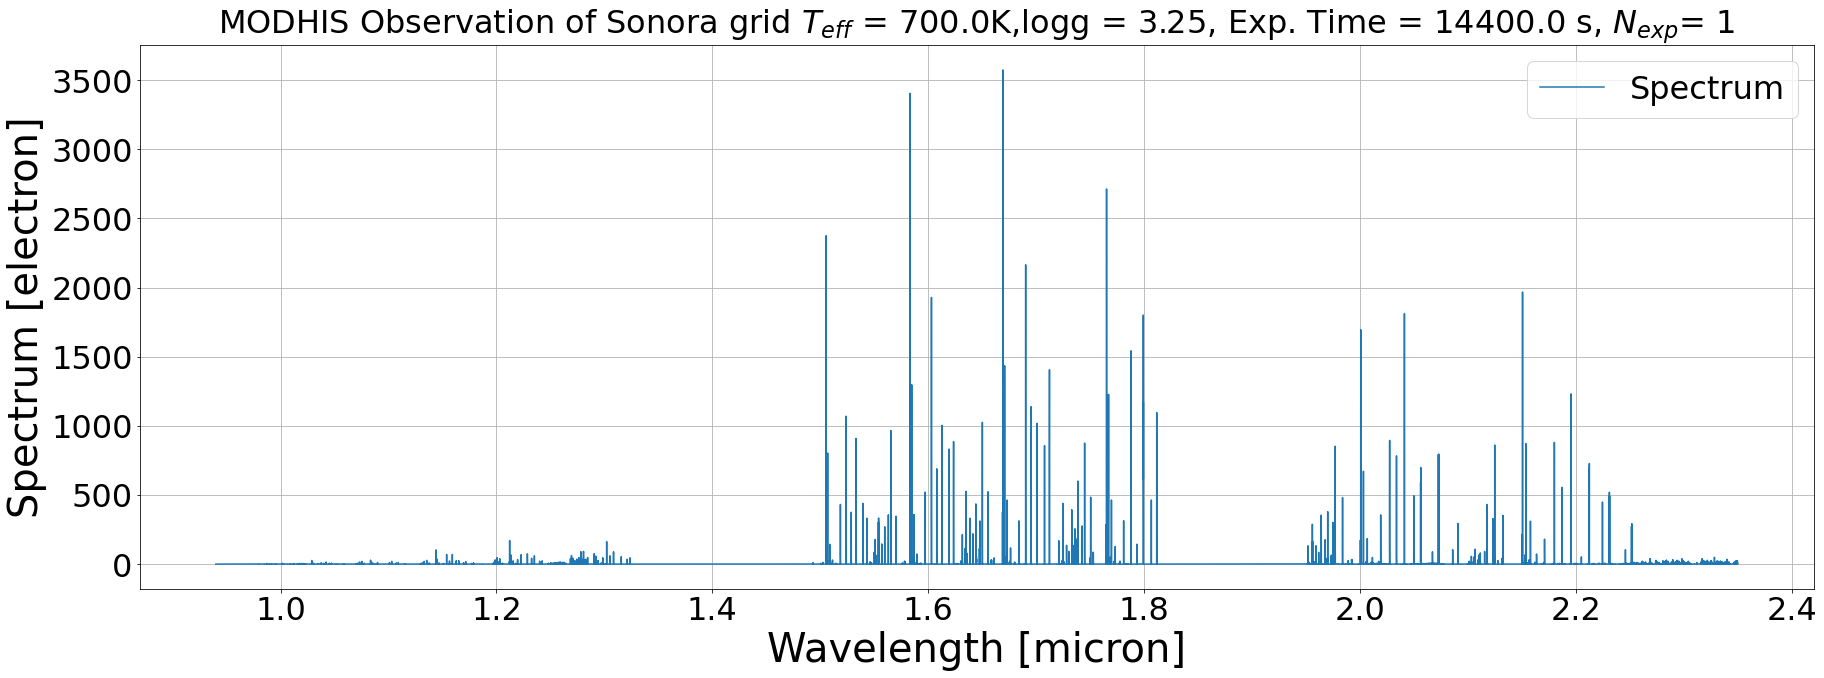

In [36]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths, full_sky,label="Spectrum")
#plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(tele.unit))
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

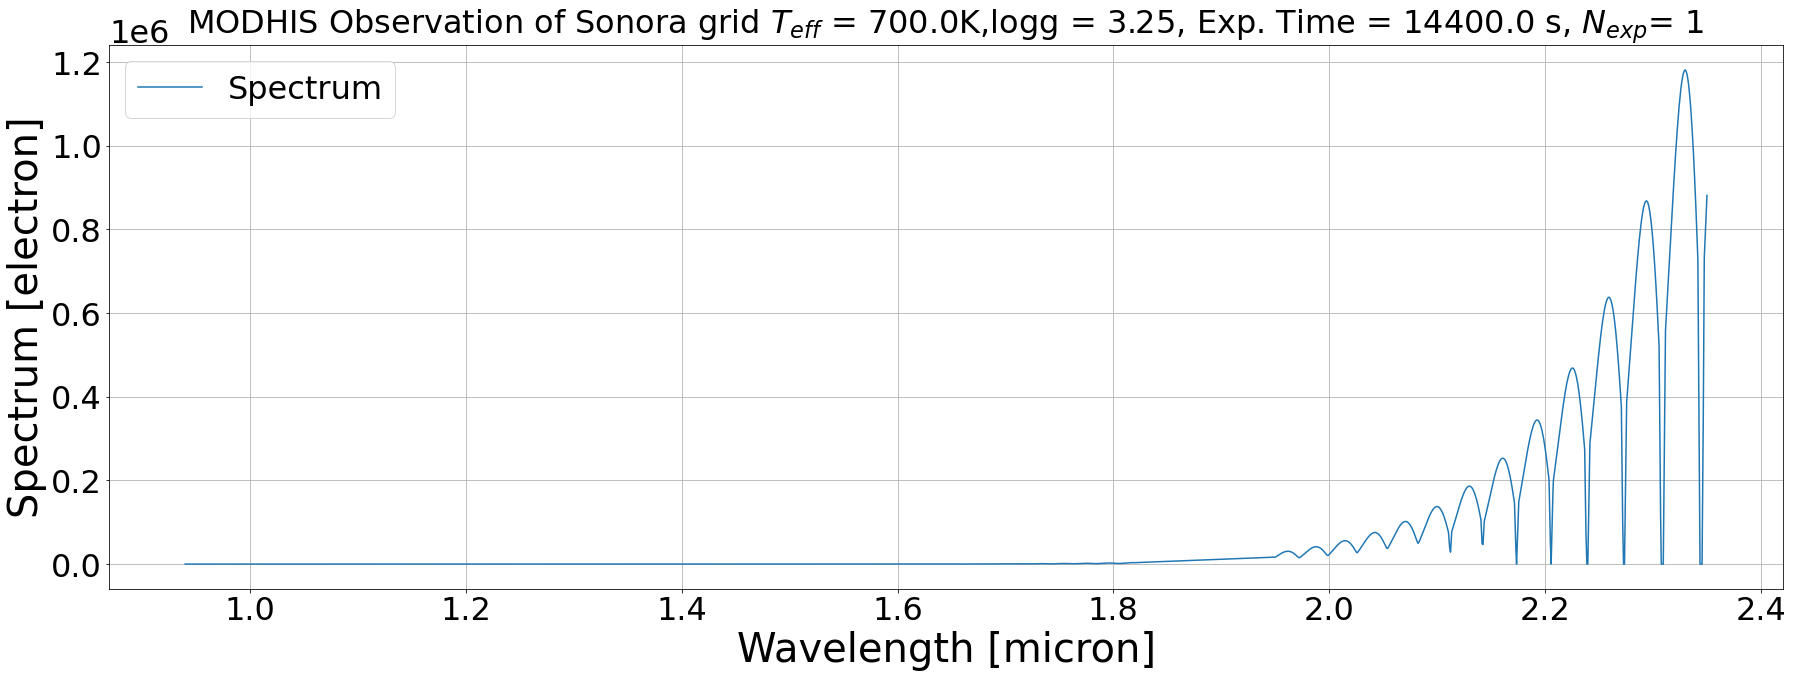

In [37]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths, full_inst,label="Spectrum")
#plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(tele.unit))
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()

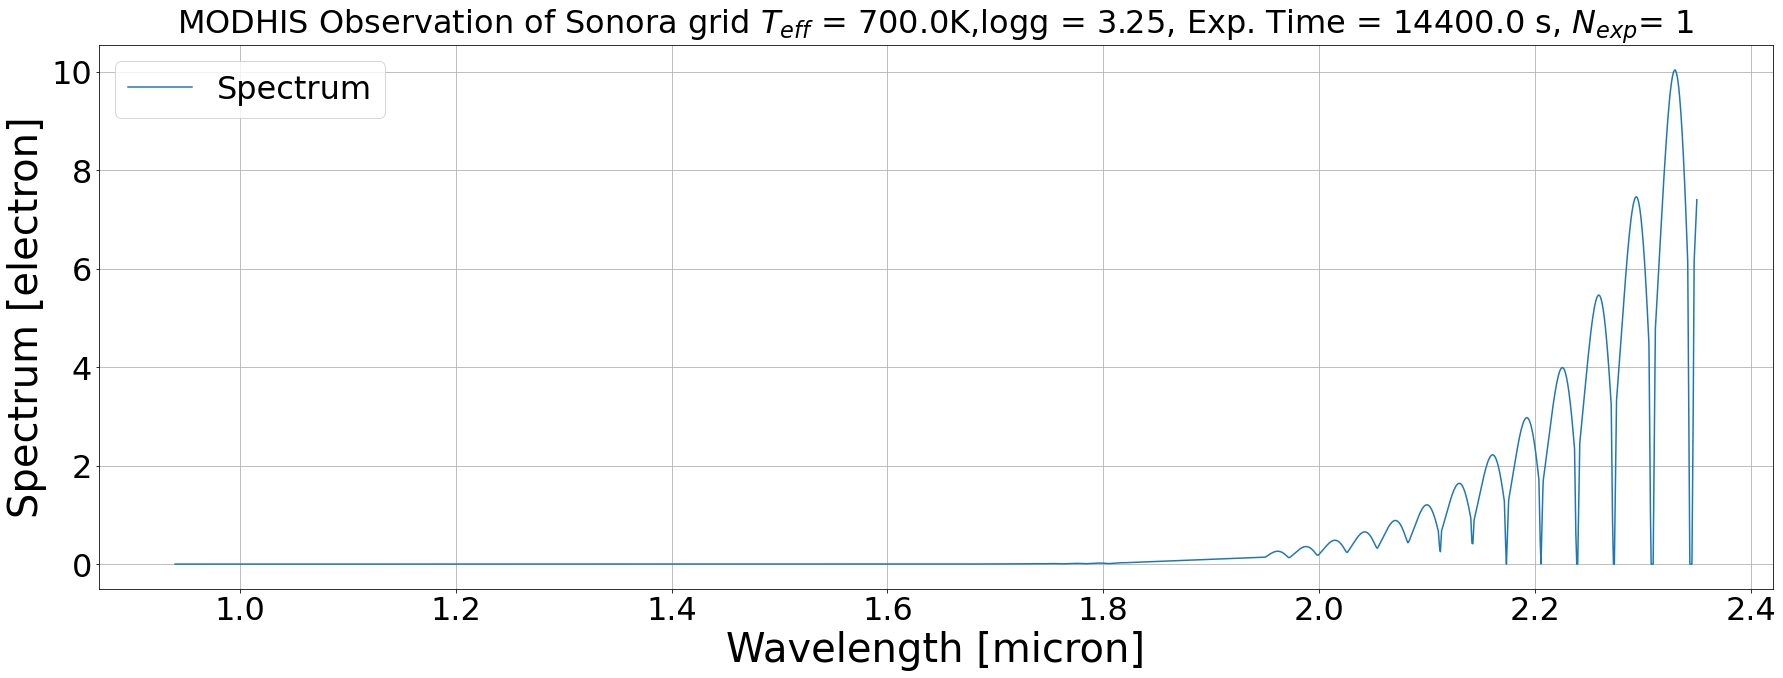

In [38]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths, full_tele,label="Spectrum")
#plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(tele.unit))
plt.title(r"MODHIS Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,modhis.exposure_time,modhis.n_exposures))
#plt.ylim(1e-4,1e2)
plt.grid()